In [7]:
!pip install qiskit qiskit_aer


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
%matplotlib inline

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def qft_rotations(qc, n):
    """Apply QFT rotations recursively on the first n qubits."""
    if n == 0:
        return qc
    n -= 1
    qc.h(n)
    for qubit in range(n):
        qc.cp(np.pi / 2**(n - qubit), qubit, n)
    qft_rotations(qc, n)
    return qc

In [11]:
def swap_registers(qc, n):
    """Swap qubits to reverse their order."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    return qc

In [12]:
def qft_circuit(n):
    """Builds an n-qubit Quantum Fourier Transform circuit."""
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    swap_registers(qc, n)
    qc.name = "QFT"
    return qc

Running Quantum Fourier Transform on 3 qubits...


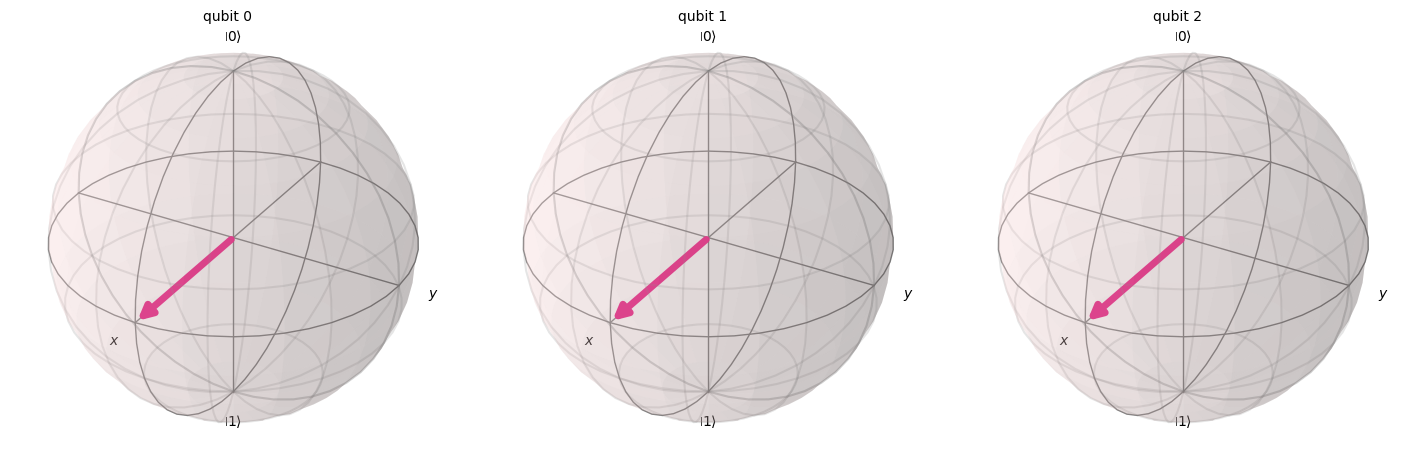

                                          ┌───┐    statevector 
q_0: ──────■──────────────────────■───────┤ H ├─X───────░──────
           │                ┌───┐ │P(π/2) └───┘ │       ░      
q_1: ──────┼────────■───────┤ H ├─■─────────────┼───────░──────
     ┌───┐ │P(π/4)  │P(π/2) └───┘               │       ░      
q_2: ┤ H ├─■────────■───────────────────────────X───────░──────
     └───┘                                              ░      


In [13]:
def run_qft(n):
    """Executes QFT circuit and displays Bloch sphere representation."""
    qc = qft_circuit(n)

    # Create a simulator and save the statevector explicitly
    simulator = AerSimulator(method='statevector')
    qc.save_statevector()

    # Transpile and run
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled).result()

    # Retrieve statevector safely
    statevector = result.data(0)["statevector"]

    # Display results
    plot_bloch_multivector(statevector)
    plt.show()
    print(qc.draw(output='text'))

if __name__ == "__main__":
    n_qubits = 3
    print(f"Running Quantum Fourier Transform on {n_qubits} qubits...")
    run_qft(n_qubits)

In [ ]:
# Task_1 :  Vary the number of Qubits

In [14]:
for n_qubits in [2, 3, 4]:
    print(f"\n--- Quantum Fourier Transform for {n_qubits} qubits ---")
    qc = qft_circuit(n_qubits)
    print(qc.draw(output='text'))


--- Quantum Fourier Transform for 2 qubits ---
                   ┌───┐   
q_0: ──────■───────┤ H ├─X─
     ┌───┐ │P(π/2) └───┘ │ 
q_1: ┤ H ├─■─────────────X─
     └───┘                 

--- Quantum Fourier Transform for 3 qubits ---
                                          ┌───┐   
q_0: ──────■──────────────────────■───────┤ H ├─X─
           │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘                                        

--- Quantum Fourier Transform for 4 qubits ---
                                                                          ┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │              

In [ ]:
'''
As the number of qubits increases, the QFT circuit grows in depth and controlled-phase gates — showing its recursive structure and increasing quantum interference complexity.
'''

In [ ]:
# Task_2 : Inverse QFT

In [15]:
def inverse_qft_circuit(n):
    qc = QuantumCircuit(n)
    swap_registers(qc, n)
    
    # Apply inverse rotations (reverse order and negative angles)
    for j in range(n - 1, -1, -1):
        for k in range(j - 1, -1, -1):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    
    qc.name = "Inverse QFT"
    return qc

iqft = inverse_qft_circuit(3)
print(iqft.draw(output='text'))

                                      ┌───┐
q_0: ─X────────────■─────────■────────┤ H ├
      │            │         │P(-π/2) ├───┤
q_1: ─┼──■─────────┼─────────■────────┤ H ├
      │  │P(-π/2)  │P(-π/4)   ┌───┐   └───┘
q_2: ─X──■─────────■──────────┤ H ├────────
                              └───┘        


In [ ]:
'''
The Inverse QFT undoes the phase rotations of the QFT — it’s the exact mirror circuit with reversed gate order and opposite rotation angles.
'''

In [ ]:
# Task_3 : Integration with Phase Estimation

In [16]:
from qiskit import QuantumCircuit
import numpy as np

def phase_estimation(unitary, num_ancillas):
    n_target = unitary.num_qubits
    qc = QuantumCircuit(num_ancillas + n_target)

    for q in range(num_ancillas):
        qc.h(q)

    for q in range(num_ancillas):
        power = 2 ** q
        qc.append(unitary.power(power).to_gate().control(1), [q] + list(range(num_ancillas, num_ancillas + n_target)))

    iqft = inverse_qft_circuit(num_ancillas)
    qc.append(iqft.to_gate(), range(num_ancillas))

    qc.measure_all()
    return qc

phi = 1/4
U = QuantumCircuit(1)
U.p(2 * np.pi * phi, 0)

qpe = phase_estimation(U, num_ancillas=3)
print(qpe.draw(output='text'))

        ┌───┐                                                   »
   q_0: ┤ H ├────────■──────────────────────────────────────────»
        ├───┤        │                                          »
   q_1: ┤ H ├────────┼────────────────■─────────────────────────»
        ├───┤        │                │                         »
   q_2: ┤ H ├────────┼────────────────┼────────────────■────────»
        └───┘┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐»
   q_3: ─────┤ circuit-54**1 ├┤ circuit-54**2 ├┤ circuit-54**4 ├»
             └───────────────┘└───────────────┘└───────────────┘»
meas: 4/════════════════════════════════════════════════════════»
                                                                »
«        ┌──────────────┐ ░ ┌─┐         
«   q_0: ┤0             ├─░─┤M├─────────
«        │              │ ░ └╥┘┌─┐      
«   q_1: ┤1 Inverse QFT ├─░──╫─┤M├──────
«        │              │ ░  ║ └╥┘┌─┐   
«   q_2: ┤2             ├─░──╫──╫─┤M├───
«        └──────────────┘ ░ 

In [ ]:
'''
This Quantum Phase Estimation circuit uses the QFT to extract the phase (eigenvalue) of a unitary — here, it estimates a phase close to ¼ (binary 0.010), demonstrating how QFT underpins quantum algorithms like Shor’s and eigenvalue finding.
'''

In [ ]:
# Task_4 : Measure Output States

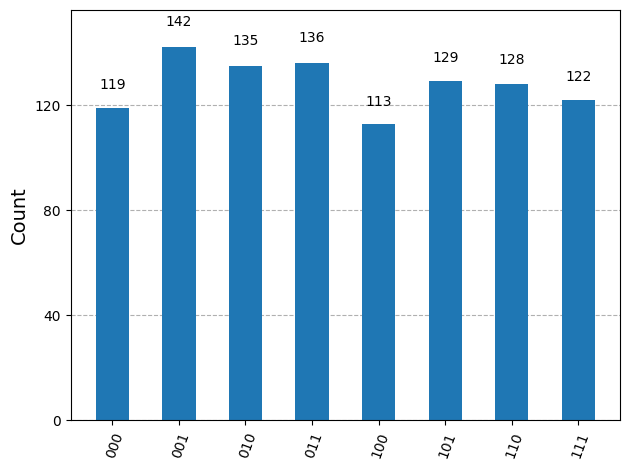

                                             ┌───┐    ░ ┌─┐      
   q_0: ──────■──────────────────────■───────┤ H ├─X──░─┤M├──────
              │                ┌───┐ │P(π/2) └───┘ │  ░ └╥┘┌─┐   
   q_1: ──────┼────────■───────┤ H ├─■─────────────┼──░──╫─┤M├───
        ┌───┐ │P(π/4)  │P(π/2) └───┘               │  ░  ║ └╥┘┌─┐
   q_2: ┤ H ├─■────────■───────────────────────────X──░──╫──╫─┤M├
        └───┘                                         ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                         0  1  2 
Measurement counts: {'110': 128, '001': 142, '000': 119, '111': 122, '011': 136, '010': 135, '100': 113, '101': 129}


In [17]:
from qiskit.visualization import plot_histogram

def run_qft_with_measurement(n):
    qc = qft_circuit(n)
    qc.measure_all()
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=1024).result()

    counts = result.get_counts()
    plot_histogram(counts)
    plt.show()
    print(qc.draw(output='text'))
    print("Measurement counts:", counts)

run_qft_with_measurement(3)

In [ ]:
'''
The histogram shows the probability distribution of measured output states — illustrating the interference pattern produced by the Quantum Fourier Transform.
'''

In [ ]:
# Task_5 : Circuit Visualization

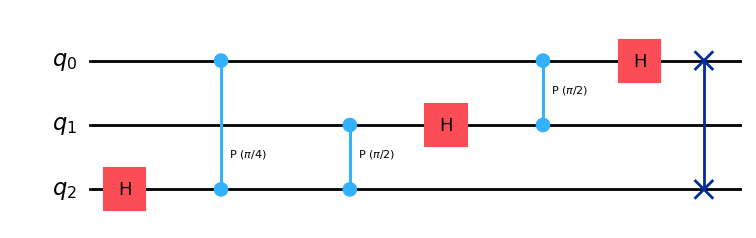

In [18]:
def visualize_qft_circuit(n):
    """Visualize the QFT circuit using matplotlib."""
    qc = qft_circuit(n)
    qc.draw('mpl')
    plt.show()

visualize_qft_circuit(3)

In [ ]:
'''
qc.draw('mpl') displays a clean, graphical circuit diagram showing Hadamard and controlled-phase gates — making the QFT’s layered structure easy to interpret visually.
'''